In [1]:
# importing packages
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output

from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torchsummary import summary

from sklearn.decomposition import PCA
import random

#### Checking which GPU we are using

In [2]:
num_gpus = torch.cuda.device_count()
for i in range(num_gpus):
    print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
    print(f"  Memory Allocated: {torch.cuda.memory_allocated(i) / 1024 ** 2:.2f} MB")
    print(f"  Memory Cached: {torch.cuda.memory_reserved(i) / 1024 ** 2:.2f} MB")
    print(f"  Memory Free: {(torch.cuda.get_device_properties(i).total_memory - torch.cuda.memory_allocated(i)) / 1024 ** 2:.2f} MB")
    print(f"  Total Memory: {torch.cuda.get_device_properties(i).total_memory / 1024 ** 2:.2f} MB")
    print()

GPU 0: NVIDIA RTX A4000
  Memory Allocated: 0.00 MB
  Memory Cached: 0.00 MB
  Memory Free: 16101.75 MB
  Total Memory: 16101.75 MB

GPU 1: NVIDIA RTX A4000
  Memory Allocated: 0.00 MB
  Memory Cached: 0.00 MB
  Memory Free: 16101.75 MB
  Total Memory: 16101.75 MB

GPU 2: NVIDIA RTX A4000
  Memory Allocated: 0.00 MB
  Memory Cached: 0.00 MB
  Memory Free: 16101.75 MB
  Total Memory: 16101.75 MB

GPU 3: NVIDIA RTX A4000
  Memory Allocated: 0.00 MB
  Memory Cached: 0.00 MB
  Memory Free: 16101.75 MB
  Total Memory: 16101.75 MB

GPU 4: NVIDIA RTX A4000
  Memory Allocated: 0.00 MB
  Memory Cached: 0.00 MB
  Memory Free: 16101.75 MB
  Total Memory: 16101.75 MB

GPU 5: NVIDIA RTX A4000
  Memory Allocated: 0.00 MB
  Memory Cached: 0.00 MB
  Memory Free: 16101.75 MB
  Total Memory: 16101.75 MB



In [3]:
if torch.cuda.is_available() and torch.cuda.device_count() > 2:
    device = torch.device("cuda:2")
    print(f"Using GPU: {torch.cuda.get_device_name(2)}")
else:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using default GPU or CPU")

Using GPU: NVIDIA RTX A4000


## Section 1.1 GAN Implimentation
* Implement a simple GAN to generate images from the MNIST dataset. Use a fully connected generator and discriminator network. Train the model and plot the loss curves for both the generator and discriminator
* Visualize the output of the generator at varioius stages of training (e.g., after 10, 50, 100 epochs) to show how the generated images evolve over time.

#### Setting up our Data

In [4]:
# Defining the transformations for out data
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Load in the MNIST dataset
mnist_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

In [5]:
# separating out dataset into trining, validation, and test sets
train_size = int(0.8 * len(mnist_data))
val_size = int(0.1 * len(mnist_data))
test_size = len(mnist_data) - train_size - val_size

train_data, val_data, test_data = random_split(mnist_data, [train_size, val_size, test_size])

# Print the sizes of each set
print(f'Train set size: {len(train_data)}')
print(f'Validation set size: {len(val_data)}')
print(f'Test set size: {len(test_data)}')

Train set size: 48000
Validation set size: 6000
Test set size: 6000


In [6]:
# creating dataloaders for each set
batch_size = 64
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

#### Building our Generator and Discriminator

In [7]:
class Generator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = torch.tanh(self.fc3(x))
        return x

class Discriminator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x


# building a way to visualize our output
def visualize_generator_output(G, z_dim, device, epoch=1, num_images=5):
    # Random noise
    z = torch.randn(num_images, z_dim).to(device)
    
    # Our fake images
    fake_images = G(z)
    
    # Reshaping our fake images to 25x25
    fake_images = fake_images.view(fake_images.size(0), 28, 28).cpu().detach().numpy()
    
    # Plot the fake images
    plt.figure(figsize=(10, 2))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(fake_images[i], cmap='gray')
        plt.axis('off')
    plt.savefig('MINST_epoch_{}.png'.format(epoch))
    plt.show()

#### Training our data

In [8]:
# global parameters
z_dim = 100
hidden_size = 512
image_size = 28 * 28
lr = 0.0001
num_epochs = 101

# Initialize generator and discriminator
G = Generator(z_dim, hidden_size, image_size).to(device)
D = Discriminator(image_size, hidden_size, 1).to(device)

# Loss and optimizers
criterion = nn.BCELoss()
G_optimizer = torch.optim.Adam(G.parameters(), lr=lr)
D_optimizer = torch.optim.Adam(D.parameters(), lr=lr)

Epoch [1/101], D Loss: 0.25746844049294787, G Loss: 3.5157046751976013
Generator output at epoch 0


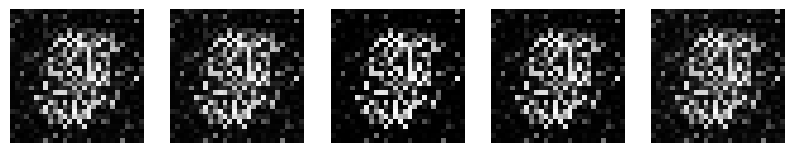

Epoch [2/101], D Loss: 0.22542321329315504, G Loss: 3.8145293701489766
Epoch [3/101], D Loss: 0.16905753154555955, G Loss: 3.692991378625234
Epoch [4/101], D Loss: 0.1133532913774252, G Loss: 4.333062552452088
Epoch [5/101], D Loss: 0.11149836721271277, G Loss: 4.741113382339478
Epoch [6/101], D Loss: 0.12533144399896265, G Loss: 5.1911201877594
Epoch [7/101], D Loss: 0.1291338962689042, G Loss: 5.327793967247009
Epoch [8/101], D Loss: 0.1222358592171222, G Loss: 5.43361093044281
Epoch [9/101], D Loss: 0.14784798807899158, G Loss: 5.632847086588542
Epoch [10/101], D Loss: 0.1417651563535134, G Loss: 5.609759410540263
Epoch [11/101], D Loss: 0.1712952498694261, G Loss: 5.384895973841349
Generator output at epoch 10


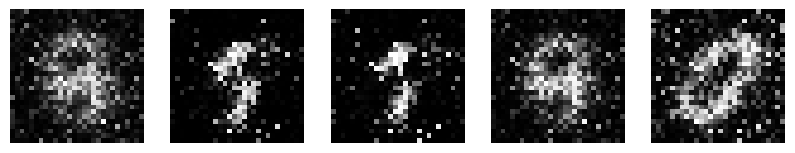

Epoch [12/101], D Loss: 0.15582097786664964, G Loss: 5.240659334818522
Epoch [13/101], D Loss: 0.14209395629664262, G Loss: 5.541826479911804
Epoch [14/101], D Loss: 0.14586233022933204, G Loss: 5.875530119895935
Epoch [15/101], D Loss: 0.1569175206919511, G Loss: 5.797133291562398
Epoch [16/101], D Loss: 0.1753307631748418, G Loss: 5.707646408398946
Epoch [17/101], D Loss: 0.1613809157734116, G Loss: 5.234826860427856
Epoch [18/101], D Loss: 0.17491459544251362, G Loss: 5.896129985173543
Epoch [19/101], D Loss: 0.18094964581231276, G Loss: 5.892307072639466
Epoch [20/101], D Loss: 0.19271657073497772, G Loss: 5.713672999064127
Epoch [21/101], D Loss: 0.21046616845826308, G Loss: 5.422704977035522
Generator output at epoch 20


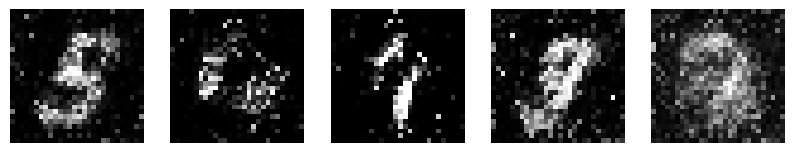

Epoch [22/101], D Loss: 0.2206404139424364, G Loss: 5.141731207847595
Epoch [23/101], D Loss: 0.2604993816316128, G Loss: 4.845699041684469
Epoch [24/101], D Loss: 0.2935932444433371, G Loss: 4.29167048184077
Epoch [25/101], D Loss: 0.29207589183251065, G Loss: 4.061542852401733
Epoch [26/101], D Loss: 0.30841872993111613, G Loss: 3.893464813550313
Epoch [27/101], D Loss: 0.29750175078709923, G Loss: 4.0018941593170165
Epoch [28/101], D Loss: 0.3123147098124027, G Loss: 4.03400851837794
Epoch [29/101], D Loss: 0.32535628738999367, G Loss: 3.8767202310562134
Epoch [30/101], D Loss: 0.2614986854890982, G Loss: 4.5863514989217125
Epoch [31/101], D Loss: 0.3553745712141196, G Loss: 3.8163653361002603
Generator output at epoch 30


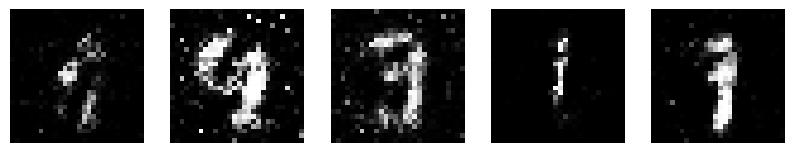

Epoch [32/101], D Loss: 0.3841906135479609, G Loss: 3.301231812477112
Epoch [33/101], D Loss: 0.4253167878985405, G Loss: 3.031923405488332
Epoch [34/101], D Loss: 0.44537584360440574, G Loss: 2.914280280590057
Epoch [35/101], D Loss: 0.4489956486026446, G Loss: 2.791144679705302
Epoch [36/101], D Loss: 0.43109118002653124, G Loss: 2.937893788019816
Epoch [37/101], D Loss: 0.3743014279206594, G Loss: 3.530116906960805
Epoch [38/101], D Loss: 0.32892135218779245, G Loss: 3.917969062169393
Epoch [39/101], D Loss: 0.45002152953545255, G Loss: 2.9957329456011452
Epoch [40/101], D Loss: 0.4956110330820084, G Loss: 2.531309234619141
Epoch [41/101], D Loss: 0.5258183196385702, G Loss: 2.4086966633796694
Generator output at epoch 40


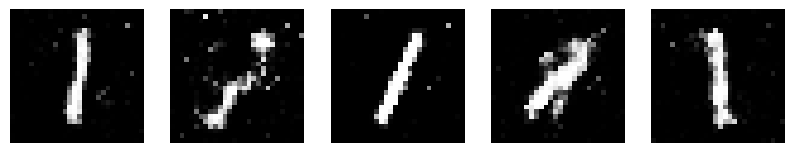

Epoch [42/101], D Loss: 0.5324964413642883, G Loss: 2.3675016673405964
Epoch [43/101], D Loss: 0.5090381191968918, G Loss: 2.4813911239306132
Epoch [44/101], D Loss: 0.5183761447469394, G Loss: 2.5189719595909117
Epoch [45/101], D Loss: 0.49991545458634695, G Loss: 2.6467657702763874
Epoch [46/101], D Loss: 0.5141294584671656, G Loss: 2.5927047837575277
Epoch [47/101], D Loss: 0.5048891844352087, G Loss: 2.5848566333452863
Epoch [48/101], D Loss: 0.5097231254776319, G Loss: 2.5724265977541605
Epoch [49/101], D Loss: 0.5504537437359492, G Loss: 2.32660728486379
Epoch [50/101], D Loss: 0.5579792071580887, G Loss: 2.2643907178243
Epoch [51/101], D Loss: 0.5637357470591863, G Loss: 2.2283269373575845
Generator output at epoch 50


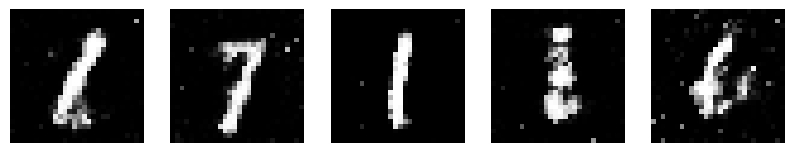

Epoch [52/101], D Loss: 0.5639291063149771, G Loss: 2.2606027210553488
Epoch [53/101], D Loss: 0.5592422008911768, G Loss: 2.3027674810091656
Epoch [54/101], D Loss: 0.5372180582284928, G Loss: 2.3816726066271463
Epoch [55/101], D Loss: 0.5250436924695968, G Loss: 2.406027840455373
Epoch [56/101], D Loss: 0.5319355227152507, G Loss: 2.4284996422131857
Epoch [57/101], D Loss: 0.5623230803012848, G Loss: 2.262356514453888
Epoch [58/101], D Loss: 0.5716349377632141, G Loss: 2.2490075713793436
Epoch [59/101], D Loss: 0.5872077031532923, G Loss: 2.1500017261505127
Epoch [60/101], D Loss: 0.6141638373533884, G Loss: 2.054756360689799
Epoch [61/101], D Loss: 0.6157493718465169, G Loss: 2.040925342082977
Generator output at epoch 60


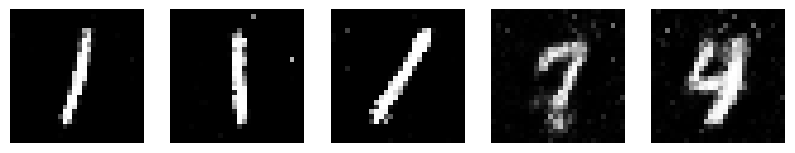

Epoch [62/101], D Loss: 0.6197638268868129, G Loss: 2.0657414433161416
Epoch [63/101], D Loss: 0.6141137746572495, G Loss: 2.0592160919507343
Epoch [64/101], D Loss: 0.6086120617787043, G Loss: 2.0926114508310953
Epoch [65/101], D Loss: 0.621795966386795, G Loss: 2.0677809127171836
Epoch [66/101], D Loss: 0.6317668943007787, G Loss: 2.0451314522425332
Epoch [67/101], D Loss: 0.6471034972667694, G Loss: 1.9754295105934143
Epoch [68/101], D Loss: 0.6461818075180054, G Loss: 2.0011621748606365
Epoch [69/101], D Loss: 0.6474827814499537, G Loss: 1.9957164157231648
Epoch [70/101], D Loss: 0.6481221319834392, G Loss: 1.9796983507474264
Epoch [71/101], D Loss: 0.6707120914856592, G Loss: 1.8969710582097372
Generator output at epoch 70


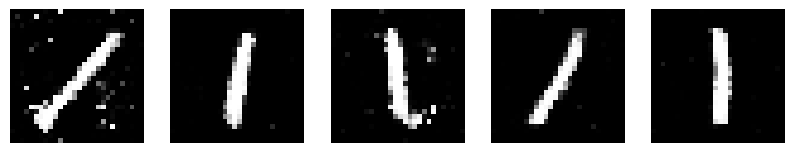

Epoch [72/101], D Loss: 0.6591011031866073, G Loss: 1.9347974699338277
Epoch [73/101], D Loss: 0.6625486292044321, G Loss: 1.9220878132184347
Epoch [74/101], D Loss: 0.6525500268141429, G Loss: 1.9327033093770345
Epoch [75/101], D Loss: 0.6685289743741354, G Loss: 1.8791121481259665
Epoch [76/101], D Loss: 0.6735826299190522, G Loss: 1.8808109744389852
Epoch [77/101], D Loss: 0.6687762859662374, G Loss: 1.885581519762675
Epoch [78/101], D Loss: 0.6796593308846156, G Loss: 1.8887691706021628
Epoch [79/101], D Loss: 0.6833706404368083, G Loss: 1.8802129521369935
Epoch [80/101], D Loss: 0.6861943520704905, G Loss: 1.8585279674530029
Epoch [81/101], D Loss: 0.6949770435492197, G Loss: 1.8345127126375833
Generator output at epoch 80


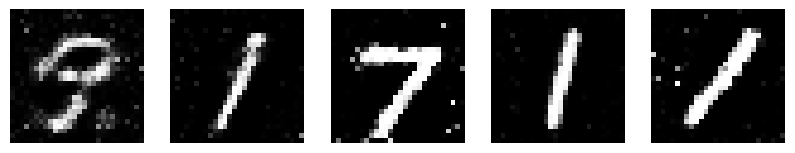

Epoch [82/101], D Loss: 0.6960598216454188, G Loss: 1.8436328625679017
Epoch [83/101], D Loss: 0.6982807494401931, G Loss: 1.831211132367452
Epoch [84/101], D Loss: 0.7004327191909154, G Loss: 1.8042820161183675
Epoch [85/101], D Loss: 0.6968955771923065, G Loss: 1.8221692611376445
Epoch [86/101], D Loss: 0.7014732428789139, G Loss: 1.8305963174502056
Epoch [87/101], D Loss: 0.7002869517405828, G Loss: 1.8393492460250855
Epoch [88/101], D Loss: 0.6998476023674012, G Loss: 1.8323452604611714
Epoch [89/101], D Loss: 0.7010949774583181, G Loss: 1.8328120668729146
Epoch [90/101], D Loss: 0.7042276401519776, G Loss: 1.8291845240592957
Epoch [91/101], D Loss: 0.7076576163768769, G Loss: 1.8220106870333355
Generator output at epoch 90


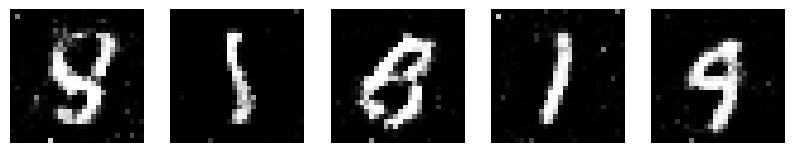

Epoch [92/101], D Loss: 0.7093503589232762, G Loss: 1.8080783144632975
Epoch [93/101], D Loss: 0.7112518744866053, G Loss: 1.8100518250465394
Epoch [94/101], D Loss: 0.7117948194344839, G Loss: 1.7909329466819763
Epoch [95/101], D Loss: 0.7167406946420669, G Loss: 1.7775652030309042
Epoch [96/101], D Loss: 0.716259870449702, G Loss: 1.7730801695187886
Epoch [97/101], D Loss: 0.715854949593544, G Loss: 1.784722486337026
Epoch [98/101], D Loss: 0.7185567679802577, G Loss: 1.7934564086596172
Epoch [99/101], D Loss: 0.7206663246949514, G Loss: 1.7782329031626383
Epoch [100/101], D Loss: 0.7245487731695175, G Loss: 1.7662556250890096
Epoch [101/101], D Loss: 0.7224894080162049, G Loss: 1.7601133530139923
Generator output at epoch 100


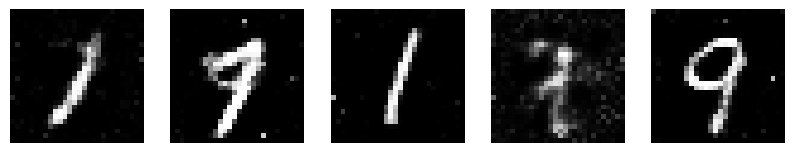

In [9]:
# Training loop
# Lists to store losses
D_losses = []
G_losses = []

for epoch in range(num_epochs):
    D_epoch_loss = 0.0
    G_epoch_loss = 0.0
    for batch_idx, (real_images, _) in enumerate(train_loader):
        batch_size = real_images.size(0)
        real_images = real_images.view(batch_size, -1).to(device)

        # Labels for real and fake data
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # Training the Discriminator
        D_optimizer.zero_grad()
        outputs = D(real_images)
        D_real_loss = criterion(outputs, real_labels)

        z = torch.randn(batch_size, z_dim).to(device)
        fake_images = G(z)
        outputs = D(fake_images.detach())
        D_fake_loss = criterion(outputs, fake_labels)

        # calculating discriminator loss
        D_loss = D_real_loss + D_fake_loss
        D_loss.backward()
        D_optimizer.step()

        # Training the Generator
        G_optimizer.zero_grad()
        z = torch.randn(batch_size, z_dim).to(device)
        fake_images = G(z)
        outputs = D(fake_images)

        # calculating Generator loss
        G_loss = criterion(outputs, real_labels)
        G_loss.backward()
        G_optimizer.step()

        # finding the loss of each epoch
        D_epoch_loss += D_loss.item()
        G_epoch_loss += G_loss.item()

    D_losses.append(D_epoch_loss / len(train_loader))
    G_losses.append(G_epoch_loss / len(train_loader))

    # printing the output of each 
    print(f'Epoch [{epoch+1}/{num_epochs}], D Loss: {D_losses[-1]}, G Loss: {G_losses[-1]}')
    
    if epoch % 10 == 0:
        print(f'Generator output at epoch {epoch}')
        visualize_generator_output(G, z_dim, epoch=epoch, device=device)

In [10]:
# Evalutating the models
G.eval()
D.eval()

G_loss = 0.0
D_loss = 0.0
with torch.no_grad():
    for batch_idx, (real_images, _) in enumerate(test_loader):
        batch_size = real_images.size(0)
        real_images = real_images.view(batch_size, -1).to(device)

        # Labels for real and fake data
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # Evaluate Discriminator
        outputs = D(real_images)
        D_real_loss = criterion(outputs, real_labels)

        z = torch.randn(batch_size, z_dim).to(device)
        fake_images = G(z)
        outputs = D(fake_images)
        D_fake_loss = criterion(outputs, fake_labels)

        D_loss += (D_real_loss + D_fake_loss).item()

        # Evaluate Generator
        outputs = D(fake_images)
        G_loss += criterion(outputs, real_labels).item()

G_loss /= len(test_loader)
D_loss /= len(test_loader)

print(f'Generator Loss: {G_loss}')
print(f'Discriminator Loss: {D_loss}')

Generator Loss: 1.6504334566440988
Discriminator Loss: 0.7170164990932384


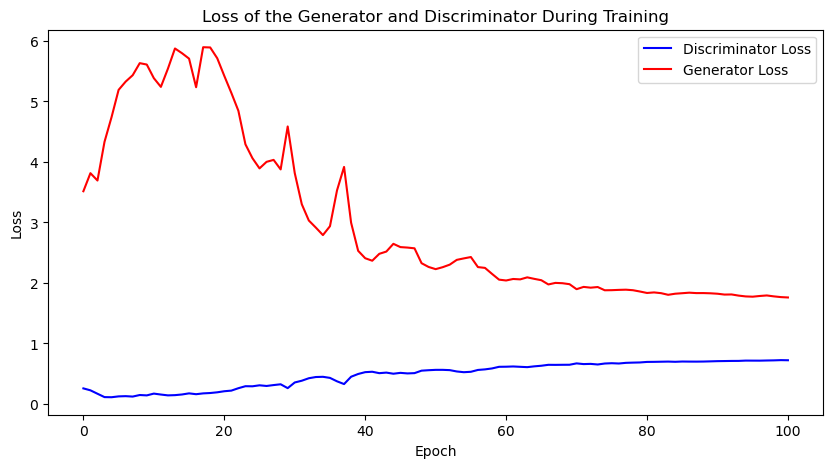

In [11]:
# plotting the loss
plt.figure(figsize=(10, 5))
plt.plot(D_losses, c='blue', label='Discriminator Loss')
plt.plot(G_losses, c='red', label='Generator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss of the Generator and Discriminator During Training')
plt.savefig('Generator_and_discriminator_loss_MINST.png')
plt.show()

## Section 1.2 DCGAN for Image Generation
Implement a Deep Convolutional GAN (DCGAN) to generate images from the CIFAR-10 dataset. Apply the following best practices during training:
* Use strided convolutions instead of pooling layers.
* Apply batch normalization in both the generator and the discriminator.
* Use the ReLU activation function in the generator and Leaky ReLU in the discriminator.

After training, visualize the generated images and compare them to the real CIFAR-10 images.

#### Setting up our Data

In [12]:
# Define the transformations for the CIFAR-10 dataset
cifar_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
batch_size = 64

# Load the CIFAR-10 dataset
cifar_data = datasets.CIFAR10(root='./data', train=True, download=True, transform=cifar_transform)

Files already downloaded and verified


In [13]:
# Split the dataset into train, validation, and test sets
cifar_train_size = int(0.8 * len(cifar_data))
cifar_val_size = int(0.1 * len(cifar_data))
cifar_test_size = len(cifar_data) - cifar_train_size - cifar_val_size

cifar_train_data, cifar_val_data, cifar_test_data = random_split(cifar_data, [cifar_train_size, cifar_val_size, cifar_test_size])

# Print the sizes of each set
print(f'CIFAR-10 Train set size: {len(cifar_train_data)}')
print(f'CIFAR-10 Validation set size: {len(cifar_val_data)}')
print(f'CIFAR-10 Test set size: {len(cifar_test_data)}')

CIFAR-10 Train set size: 40000
CIFAR-10 Validation set size: 5000
CIFAR-10 Test set size: 5000


In [14]:
# Create dataloaders for each set
cifar_train_loader = DataLoader(cifar_train_data, batch_size=batch_size, shuffle=True)
cifar_val_loader = DataLoader(cifar_val_data, batch_size=batch_size, shuffle=False)
cifar_test_loader = DataLoader(cifar_test_data, batch_size=batch_size, shuffle=False)

#### Building our Generator and Discriminator

In [15]:
class DCGAN_Generator(nn.Module):
    def __init__(self, z_dim, img_channels, feature_g):
        super(DCGAN_Generator, self).__init__()
        self.gen = nn.Sequential(
            # Input: N x z_dim x 1 x 1
            nn.ConvTranspose2d(z_dim, feature_g * 16, kernel_size=4, stride=1, padding=0),
            nn.BatchNorm2d(feature_g * 16),
            nn.ReLU(True),
            # State: N x (feature_g*16) x 4 x 4

            nn.ConvTranspose2d(feature_g * 16, feature_g * 8, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(feature_g * 8),
            nn.ReLU(True),
            # State: N x (feature_g*8) x 8 x 8

            nn.ConvTranspose2d(feature_g * 8, feature_g * 4, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(feature_g * 4),
            nn.ReLU(True),
            # State: N x (feature_g*4) x 16 x 16

            nn.ConvTranspose2d(feature_g * 4, feature_g * 2, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(feature_g * 2),
            nn.ReLU(True),
            # State: N x (feature_g*2) x 32 x 32

            nn.ConvTranspose2d(feature_g * 2, img_channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
            # Output: N x img_channels x 64 x 64
        )

    def forward(self, x):
        return self.gen(x)

class DCGAN_Discriminator(nn.Module):
    def __init__(self, img_channels, feature_d):
        super(DCGAN_Discriminator, self).__init__()
        self.disc = nn.Sequential(
            # Input: N x img_channels x 64 x 64
            nn.Conv2d(img_channels, feature_d, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            # State: N x feature_d x 32 x 32

            nn.Conv2d(feature_d, feature_d * 2, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(feature_d * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # State: N x (feature_d*2) x 16 x 16

            nn.Conv2d(feature_d * 2, feature_d * 4, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(feature_d * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # State: N x (feature_d*4) x 8 x 8

            nn.Conv2d(feature_d * 4, feature_d * 8, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(feature_d * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # State: N x (feature_d*8) x 4 x 4

            nn.Conv2d(feature_d * 8, 1, kernel_size=4, stride=1, padding=0),
            nn.Sigmoid()
            # Output: N x 1 x 1 x 1
        )

    def forward(self, x):
        return self.disc(x).view(-1, 1).squeeze(1)

def visualize_generator_output(G, z_dim, device, epoch=1, num_images=5):
    # Generate random noise
    z = torch.randn(num_images, z_dim, 1, 1).to(device)  # Reshape to 4D tensor
    
    # Generate fake images
    fake_images = G(z)
    
    # Reshape fake images to 64x64
    fake_images = fake_images.view(fake_images.size(0), 3, 64, 64).cpu().detach().numpy()
    
    # Plot the fake images
    plt.figure(figsize=(10, 2))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(np.transpose(fake_images[i], (1, 2, 0)) * 0.5 + 0.5)  # Rescale to [0, 1] and transpose to (H, W, C)
        plt.axis('off')
        plt.savefig('CIFAR_epoch_{}.png'.format(epoch))
    plt.show()

#### Training our Data

In [16]:
# Global Parameters
z_dim = 512
img_channels = 3
feature_g = 64
feature_d = 64 ## reduced the number of features to solve gradient vanishing problem

lr = 5e-4
num_epochs = 51

In [17]:
# Initialize generator and discriminator
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
G = DCGAN_Generator(z_dim, img_channels, feature_g).to(device)
D = DCGAN_Discriminator(img_channels, feature_d).to(device)

# Loss and optimizers
criterion = nn.BCELoss()
G_optimizer = torch.optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
D_optimizer = torch.optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))

Epoch [1/51], D Loss: 0.8276929330259561, G Loss: 4.164353017663956
Generator output at epoch 0


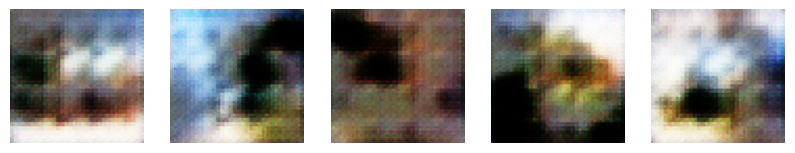

Epoch [2/51], D Loss: 0.7181972958270461, G Loss: 3.7150904983483253
Epoch [3/51], D Loss: 0.8366288707479834, G Loss: 3.429886785030365
Epoch [4/51], D Loss: 0.7795697163403035, G Loss: 3.598515390026569
Epoch [5/51], D Loss: 0.8231337851822377, G Loss: 2.9786796514987945
Epoch [6/51], D Loss: 0.7008219482541085, G Loss: 3.3680909710645675
Epoch [7/51], D Loss: 0.6171791716396808, G Loss: 3.5244015980243684
Epoch [8/51], D Loss: 0.6650412719845772, G Loss: 3.2977816638469695
Epoch [9/51], D Loss: 0.641692775017023, G Loss: 3.274259021472931
Epoch [10/51], D Loss: 0.5188569637417794, G Loss: 3.391222243690491
Epoch [11/51], D Loss: 0.5488618721708656, G Loss: 3.3751601343035698
Generator output at epoch 10


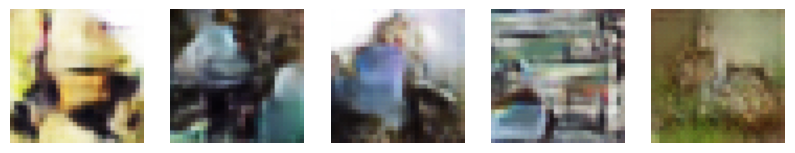

Epoch [12/51], D Loss: 0.4270238051354885, G Loss: 3.7487015437573192
Epoch [13/51], D Loss: 0.3799243773788214, G Loss: 4.048780470502376
Epoch [14/51], D Loss: 0.40019832005500794, G Loss: 3.9204060272932053
Epoch [15/51], D Loss: 0.4192028086662292, G Loss: 3.983293136930466
Epoch [16/51], D Loss: 0.25463241068273784, G Loss: 4.618140244842693
Epoch [17/51], D Loss: 0.36712775651663543, G Loss: 4.382532393816113
Epoch [18/51], D Loss: 0.27878584862053396, G Loss: 4.516735324633122
Epoch [19/51], D Loss: 0.21308890515491366, G Loss: 4.756488258266449
Epoch [20/51], D Loss: 0.3317225647445768, G Loss: 4.856656986095756
Epoch [21/51], D Loss: 0.17647526451535522, G Loss: 5.043594418096542
Generator output at epoch 20


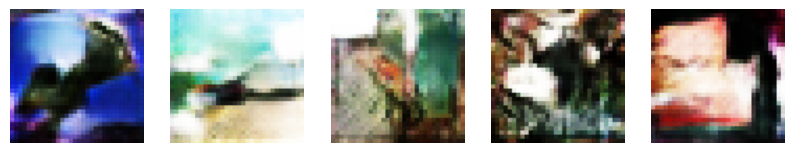

Epoch [22/51], D Loss: 0.49761739794388415, G Loss: 4.308207941514254
Epoch [23/51], D Loss: 0.24110199031531812, G Loss: 4.640561024916172
Epoch [24/51], D Loss: 0.24315485633164644, G Loss: 5.1858207058101895
Epoch [25/51], D Loss: 0.2841974507763982, G Loss: 4.7458519246459
Epoch [26/51], D Loss: 0.2183392178028822, G Loss: 4.9469061024308205
Epoch [27/51], D Loss: 0.20211318533718586, G Loss: 5.354639781379699
Epoch [28/51], D Loss: 0.23477526243105531, G Loss: 5.053283859358728
Epoch [29/51], D Loss: 0.19334908046945928, G Loss: 5.309274597120285
Epoch [30/51], D Loss: 0.20456136742010714, G Loss: 5.2752785805404185
Epoch [31/51], D Loss: 0.23501923566013574, G Loss: 5.372495212317258
Generator output at epoch 30


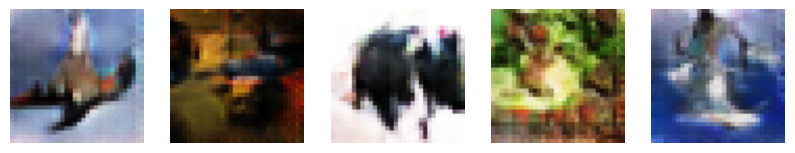

Epoch [32/51], D Loss: 0.2527631652381271, G Loss: 4.978434017980098
Epoch [33/51], D Loss: 0.2138388186916709, G Loss: 5.15762350063324
Epoch [34/51], D Loss: 0.10575338418353349, G Loss: 5.771912450504303
Epoch [35/51], D Loss: 0.17761905780043452, G Loss: 5.7768238630533215
Epoch [36/51], D Loss: 0.291388744790107, G Loss: 5.297635372627899
Epoch [37/51], D Loss: 0.1250902275598608, G Loss: 5.771994714736938
Epoch [38/51], D Loss: 0.11636907354705035, G Loss: 5.837845575046539
Epoch [39/51], D Loss: 0.21858248150516302, G Loss: 5.558768139564991
Epoch [40/51], D Loss: 0.1886865358842537, G Loss: 5.936504030942917
Epoch [41/51], D Loss: 0.20480648504085838, G Loss: 5.17942109901309
Generator output at epoch 40


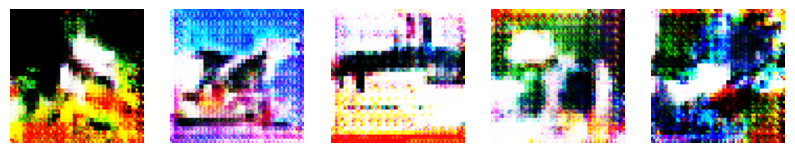

Epoch [42/51], D Loss: 0.2386029394261539, G Loss: 5.556289153957367
Epoch [43/51], D Loss: 0.07488368346448988, G Loss: 6.0410592510938645
Epoch [44/51], D Loss: 0.29830547535563817, G Loss: 5.358631599104404
Epoch [45/51], D Loss: 0.19381336805578323, G Loss: 5.369722977617383
Epoch [46/51], D Loss: 0.25456445664092897, G Loss: 5.07194737512325
Epoch [47/51], D Loss: 0.12907372258789837, G Loss: 5.60159735930115
Epoch [48/51], D Loss: 0.21656753438450396, G Loss: 5.82319509831667
Epoch [49/51], D Loss: 0.18770471951365472, G Loss: 5.340810724067688
Epoch [50/51], D Loss: 0.10694608269501478, G Loss: 5.952721630477905
Epoch [51/51], D Loss: 0.231424686284177, G Loss: 5.582139173328876
Generator output at epoch 50


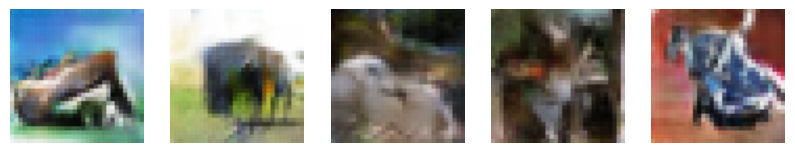

In [18]:
# Training loop
D_losses = []
G_losses = []

for epoch in range(num_epochs):
    D_epoch_loss = 0.0
    G_epoch_loss = 0.0
    for batch_idx, (real_images, _) in enumerate(cifar_train_loader):
        real_images = real_images.to(device)
        real_images = real_images.to(device)
        real_images = F.interpolate(real_images, size=(64, 64))  # Resize real images to 64x64

        real_labels = torch.ones(batch_size, 1).to(device).view(-1)
        fake_labels = torch.zeros(batch_size, 1).to(device).view(-1)
        fake_labels = torch.zeros(batch_size, 1).to(device).view(-1)

        # Train Discriminator
        D_optimizer.zero_grad()
        outputs = D(real_images)
        D_real_loss = criterion(outputs, real_labels)
        z = torch.randn(batch_size, z_dim, 1, 1).to(device)
        z = torch.randn(batch_size, z_dim, 1, 1).to(device)
        fake_images = G(z)
        outputs = D(fake_images.detach())
        D_fake_loss = criterion(outputs, fake_labels)

        D_loss = D_real_loss + D_fake_loss
        D_loss.backward()
        D_optimizer.step()

        # Train Generator
        G_optimizer.zero_grad()
        z = torch.randn(batch_size, z_dim, 1, 1).to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
        fake_images = G(z)
        outputs = D(fake_images)
        G_loss = criterion(outputs, real_labels)

        G_loss.backward()
        G_optimizer.step()

        D_epoch_loss += D_loss.item()
        G_epoch_loss += G_loss.item()

    D_losses.append(D_epoch_loss / len(cifar_train_loader))
    G_losses.append(G_epoch_loss / len(cifar_train_loader))

    print(f'Epoch [{epoch+1}/{num_epochs}], D Loss: {D_losses[-1]}, G Loss: {G_losses[-1]}')
    
    if epoch % 10 == 0:
        print(f'Generator output at epoch {epoch}')
        visualize_generator_output(G, z_dim, epoch=epoch, device=device)

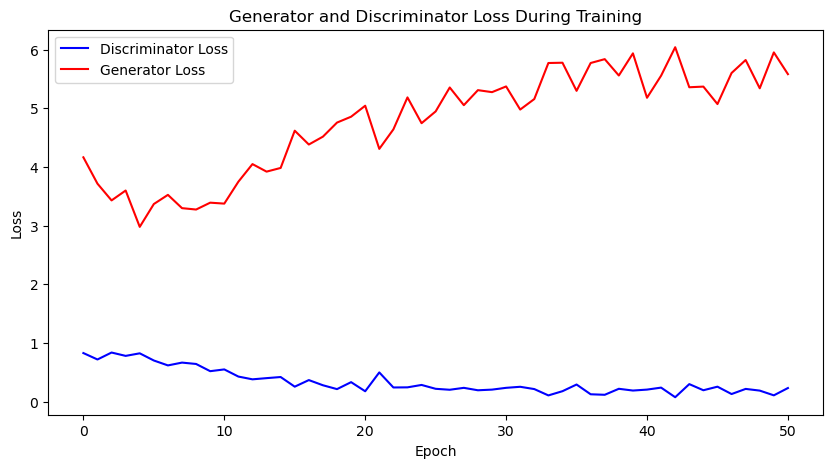

In [19]:
plt.figure(figsize=(10, 5))
plt.plot(D_losses, c='blue', label='Discriminator Loss')
plt.plot(G_losses, c='red', label='Generator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Generator and Discriminator Loss During Training')
plt.savefig('Generator_and_discriminator_loss_CIFAR.png')
plt.show()

In [ ]:
cifar_test_data

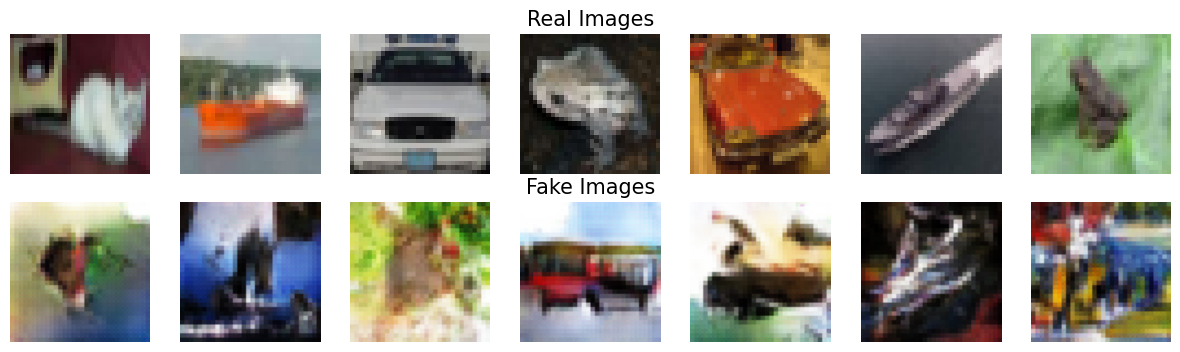

In [68]:
num_images=7
# Generate random noise
z = torch.randn(num_images, z_dim, 1, 1).to(device)

# Generate fake images
fake_images = G(z)

# Get real images
real_images, _ = next(iter(cifar_test_loader))
real_images = real_images[:num_images].to(device)

# Reshape fake images to 64x64
fake_images = fake_images.view(fake_images.size(0), 3, 64, 64).cpu().detach().numpy()
real_images = real_images.view(real_images.size(0), 3, 32, 32).cpu().detach().numpy()

# Plot the fake and real images
plt.figure(figsize=(15, 4))
for i in range(num_images):
    # Plot real images
    plt.subplot(2, num_images, i + 1)
    plt.imshow(np.transpose(real_images[i], (1, 2, 0)) * 0.5 + 0.5)  # Rescale to [0, 1] and transpose to (H, W, C)
    plt.axis('off')
    if i == num_images // 2:
        plt.title('Real Images',size=15)
    
    # Plot fake images
    plt.subplot(2, num_images, num_images + i + 1)
    plt.imshow(np.transpose(fake_images[i], (1, 2, 0)) * 0.5 + 0.5)  # Rescale to [0, 1] and transpose to (H, W, C)
    plt.axis('off')
    if i == num_images // 2:
        # Add title for fake images
        plt.title('Fake Images',size=15)

plt.savefig('real_vs_fake_CIFAR.png')
plt.show()

## Section 1.3 Latent Space Interpolation in GANs:
Implement latent space interpolation between two generated images. Select two distinct latent vectors, interpolate between them using linear interpolation, and visualize the resulting images. Comment on how smooth or realistic the transitions are.

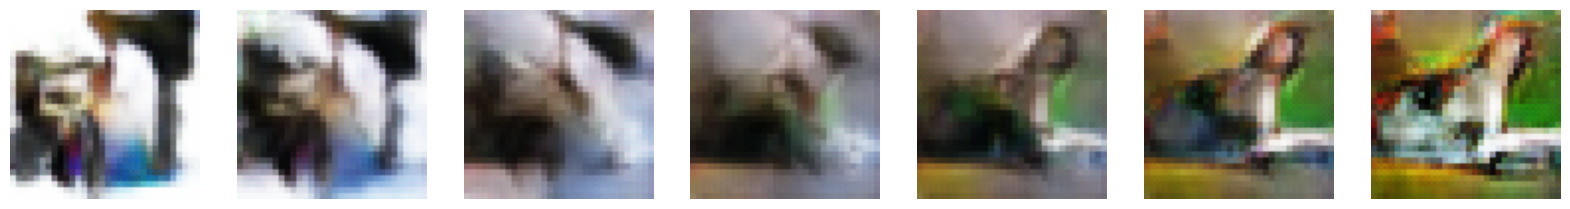

In [75]:
interpolation_steps = 7

# Select two distinct latent vectors
z1 = torch.randn(1, z_dim, 1, 1).to(device)
z2 = torch.randn(1, z_dim, 1, 1).to(device)

# Interpolate between the two latent vectors
interpolated_z = [z1 * (1 - alpha) + z2 * alpha for alpha in np.linspace(0, 1, interpolation_steps)]
interpolated_z = torch.cat(interpolated_z, dim=0)

# Generate images from the interpolated latent vectors
with torch.no_grad():
    interpolated_images = G(interpolated_z)

# Reshape images to 64x64
interpolated_images = interpolated_images.view(interpolated_images.size(0), 3, 64, 64).cpu().numpy()

# Visualize the resulting images
plt.figure(figsize=(20, 4))
for i in range(interpolation_steps):
    plt.subplot(1, interpolation_steps, i + 1)
    plt.imshow(np.transpose(interpolated_images[i], (1, 2, 0)) * 0.5 + 0.5)  # Rescale to [0, 1] and transpose to (H, W, C)
    plt.axis('off')
    plt.savefig('Interploation.png')
plt.show()

The images generated by the generator is not really good as we can only make out certain distinct shapes from it, but just looking at the transition itself, we can say that it is pretty good as there is no jarring or abrud jump in the transition. The generated images smootly transisitons to another image. This helps us verify that that the GAN's latent space is continuous and well-structured.

## Section 2.1 VAE Impementation for Image Generation
* Implement a Variational Autoencoder (VAE) for the MNIST dataset. Train the model to
reconstruct input images and generate new images by sampling from the learned latent space.
* Visualize both the reconstruction and the newly generated images. Plot the ELBO (Evidence
Lower Bound) loss and KL-divergence during training.

#### Setting up our Data

In [38]:
# Setting up the MNIST dataset again
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.0,), (1.0,))])


# download the MNIST datasets
path = 'data'
train_dataset = MNIST(path, transform=transform, download=True)
test_dataset  = MNIST(path, transform=transform, download=True)

In [39]:
# create train and test dataloaders
batch_size = 100
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

#### Building our VAE Model

In [40]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        
        # Convolutional blocks
        self.cnn_block1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=4, stride=2, padding=1)
        )
        self.cnn_block2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=4, stride=2, padding=1)
        )
        self.cnn_block3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1)
        )
        
        # 1x1 convolution for channel matching in skip connection
        self.skip_conv1 = nn.Conv2d(16, 32, kernel_size=1, stride=1)
        self.skip_conv2 = nn.Conv2d(32, 64, kernel_size=1, stride=1)

        # Encoder layers for latent variables
        self.Flatten = nn.Flatten()
        self.mean_layer = nn.Linear(64 * 3 * 3, 2)
        self.logvar_layer = nn.Linear(64 * 3 * 3, 2)

        # Decoder layers
        self.decoder = nn.Sequential(
            nn.Linear(2, 64 * 3 * 3),
            nn.ReLU(),
            nn.Unflatten(1, (64, 3, 3)),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=3, padding=1),  # 3x3 -> 7x7
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=2),  # 7x7 -> 14x14
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=4, stride=2, padding=1),  # 14x14 -> 28x28
            nn.Sigmoid()
        )

    def encode(self, x):
        # Forward pass with skip connections before ReLU
        x1 = self.cnn_block1(x)  # Shape: (batch_size, 16, 14, 14)
        x2 = self.cnn_block2(x1)  # Shape: (batch_size, 32, 7, 7)
        
        # Skip connection: use 1x1 convolution to match the channels
        x1_skip = self.skip_conv1(x1)  # Now (batch_size, 32, 14, 14)
        x2 = x2 + nn.functional.interpolate(x1_skip, size=x2.shape[2:])  # Add skip connection before ReLU
        x2 = nn.ReLU()(x2)
        
        x3 = self.cnn_block3(x2)  # Shape: (batch_size, 64, 3, 3)
        
        # Skip connection between cnn_block2 and cnn_block3
        x2_skip = self.skip_conv2(x2)  # Now (batch_size, 64, 7, 7)
        x3 = x3 + nn.functional.interpolate(x2_skip, size=x3.shape[2:])  # Add skip connection before ReLU
        x3 = nn.ReLU()(x3)
        
        # Flatten and pass through latent layers
        x_flattened = self.Flatten(x3)
        mean = self.mean_layer(x_flattened)
        logvar = self.logvar_layer(x_flattened)
        return mean, logvar

    def reparameterization(self, mean, logvar):
        # Reparameterization trick
        epsilon = torch.randn_like(logvar)
        z = mean + torch.exp(0.5 * logvar) * epsilon  # exp(logvar / 2) for standard deviation
        return z

    def decode(self, z):
        # Pass through the decoder
        return self.decoder(z)

    def forward(self, x):
        mean, logvar = self.encode(x)
        z = self.reparameterization(mean, logvar)
        x_hat = self.decode(z)
        return x_hat, mean, logvar

In [41]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize model and print summary
model = VAE().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 14, 14]             272
            Conv2d-2             [-1, 32, 7, 7]           8,224
            Conv2d-3           [-1, 32, 14, 14]             544
            Conv2d-4             [-1, 64, 3, 3]          32,832
            Conv2d-5             [-1, 64, 7, 7]           2,112
           Flatten-6                  [-1, 576]               0
            Linear-7                    [-1, 2]           1,154
            Linear-8                    [-1, 2]           1,154
            Linear-9                  [-1, 576]           1,728
             ReLU-10                  [-1, 576]               0
        Unflatten-11             [-1, 64, 3, 3]               0
  ConvTranspose2d-12             [-1, 32, 8, 8]          32,800
             ReLU-13             [-1, 32, 8, 8]               0
  ConvTranspose2d-14           [-1, 16,

#### Building our Loss Function

In [42]:
def loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    KLD = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())
    # print(KLD,reproduction_loss + KLD)
    return reproduction_loss + KLD,KLD

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [43]:
def train(model, optimizer, epochs, device):
    model.train()
    train_losses = []
    val_losses = []
    kld_total = []

    for epoch in range(epochs):
        overall_train_loss = 0
        overall_val_loss = 0
        overall_kld = 0

        # Training loop
        model.train()
        for batch_idx, (x, y) in enumerate(train_loader):  # Include y in the loop
            x = x.to(device)
            y = y.to(device)

            optimizer.zero_grad()

            x_hat, mean, log_var = model(x)
            loss , kld = loss_function(x, x_hat, mean, log_var)  # Use the provided loss function
            
            overall_train_loss += loss.sum().item()  # Summing the losses manually
            overall_kld += kld.sum().item()

            loss.mean().backward()  # Taking the mean for backward pass
            optimizer.step()

        avg_train_loss = overall_train_loss / (batch_idx * batch_size)
        train_losses.append(avg_train_loss)
        kld_total.append(overall_kld/(batch_idx * batch_size))

        # Validation loop
        model.eval()
        with torch.no_grad():
            for batch_idx, (x, y) in enumerate(test_loader):
                x = x.to(device)
                y = y.to(device)

                x_hat, mean, log_var = model(x)
                val_loss,_ = loss_function(x, x_hat, mean, log_var)
                
                overall_val_loss += val_loss.sum().item()

        avg_val_loss = overall_val_loss / (batch_idx * batch_size)
        val_losses.append(avg_val_loss)

        print(f"Epoch {epoch + 1} \tTrain Loss: {avg_train_loss} \tValidation Loss: {avg_val_loss}")
    
    return train_losses, val_losses,kld_total

In [45]:
epochs=51
model.train()
train_losses = []
val_losses = []
kld_total = []

for epoch in range(epochs):
    overall_train_loss = 0
    overall_val_loss = 0
    overall_kld = 0

    # Training loop
    model.train()
    for batch_idx, (x, y) in enumerate(train_loader):  # Include y in the loop
        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()

        x_hat, mean, log_var = model(x)
        loss , kld = loss_function(x, x_hat, mean, log_var)  # Use the provided loss function
        
        overall_train_loss += loss.sum().item()  # Summing the losses manually
        overall_kld += kld.sum().item()

        loss.mean().backward()  # Taking the mean for backward pass
        optimizer.step()

    avg_train_loss = overall_train_loss / (batch_idx * batch_size)
    train_losses.append(avg_train_loss)
    kld_total.append(overall_kld/(batch_idx * batch_size))

    # Validation loop
    model.eval()
    with torch.no_grad():
        for batch_idx, (x, y) in enumerate(test_loader):
            x = x.to(device)
            y = y.to(device)

            x_hat, mean, log_var = model(x)
            val_loss,_ = loss_function(x, x_hat, mean, log_var)
            
            overall_val_loss += val_loss.sum().item()

    avg_val_loss = overall_val_loss / (batch_idx * batch_size)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch + 1} \tTrain Loss: {avg_train_loss} \tValidation Loss: {avg_val_loss}")

Epoch 1 	Train Loss: 200.86033100414753 	Validation Loss: 170.67374315265025
Epoch 2 	Train Loss: 164.03075656693449 	Validation Loss: 160.3951587280885
Epoch 3 	Train Loss: 158.38237177522433 	Validation Loss: 156.71427000730384
Epoch 4 	Train Loss: 155.56967003925814 	Validation Loss: 153.94779001786833
Epoch 5 	Train Loss: 153.70791296040275 	Validation Loss: 152.35759780297892
Epoch 6 	Train Loss: 152.19834057739462 	Validation Loss: 151.5319639503339
Epoch 7 	Train Loss: 151.24896779463168 	Validation Loss: 150.93383006508242
Epoch 8 	Train Loss: 150.3380055463533 	Validation Loss: 149.69163927183325
Epoch 9 	Train Loss: 149.68008004877922 	Validation Loss: 149.2647759938439
Epoch 10 	Train Loss: 149.079192045336 	Validation Loss: 148.2604751897694
Epoch 11 	Train Loss: 148.65908268337856 	Validation Loss: 148.47910824681762
Epoch 12 	Train Loss: 148.17791569934266 	Validation Loss: 147.62662790849333
Epoch 13 	Train Loss: 147.6963199081803 	Validation Loss: 147.22700306174352
Epo

#### Showing the Loss

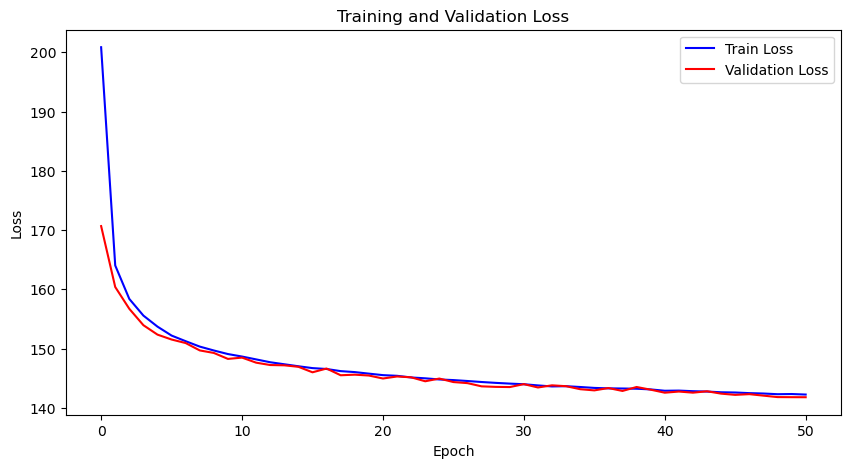

In [46]:
# Plotting the loss
clear_output(wait=True)
plt.figure(figsize=(10, 5))
plt.plot(train_losses,c='blue', label='Train Loss')
plt.plot(val_losses,c='red', label='Validation Loss')

# plt.plot(kld_total, label='KLD Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

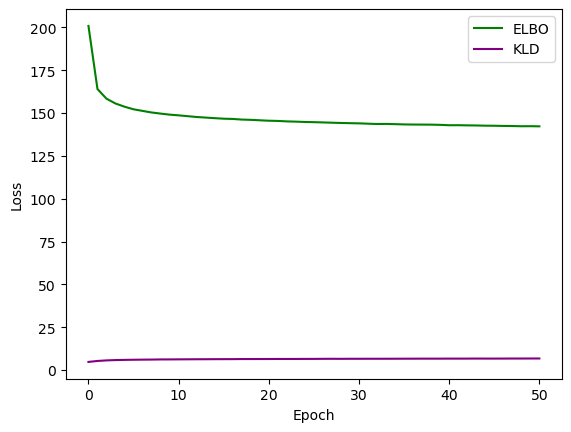

In [54]:
plt.plot(train_losses, label='ELBO',c='green')
plt.plot(kld_total, label='KLD',c='purple')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('elbo_vs_kld.png')
plt.show()

In [78]:
def visualize_reconstruction_and_generation(model, test_loader, z_dim, device, num_images=5):
    model.eval()
    
    # Get a batch of real images
    real_images, _ = next(iter(test_loader))
    real_images = real_images[:num_images].to(device)
    
    # Reconstruct images
    with torch.no_grad():
        reconstructed_images, _, _ = model(real_images)
    
    # Generate new images
    z = torch.randn(num_images, z_dim).to(device)
    with torch.no_grad():
        generated_images = model.decode(z)
    
    # Move images to CPU and convert to numpy
    real_images = real_images.cpu().numpy()
    reconstructed_images = reconstructed_images.cpu().numpy()
    generated_images = generated_images.cpu().numpy()
    
    # Plot the images
    plt.figure(figsize=(10, 6))

    for i in range(num_images):
        # Plot real images
        plt.subplot(3, num_images, i + 1)
        plt.imshow(real_images[i].reshape(28, 28), cmap='gray')
        plt.axis('off')
        if i == num_images // 2:
            plt.title('Real Images')
        
        # Plot reconstructed images
        plt.subplot(3, num_images, num_images + i + 1)
        plt.imshow(reconstructed_images[i].reshape(28, 28), cmap='gray')
        plt.axis('off')
        if i == num_images // 2:
            plt.title('Reconstructed Images')
        
        # Plot generated images
        plt.subplot(3, num_images, 2 * num_images + i + 1)
        plt.imshow(generated_images[i].reshape(28, 28), cmap='gray')
        plt.axis('off')
        if i == num_images // 2:
            plt.title('Generated Images')

    plt.savefig('VAE_real_vs_fake.png')
    plt.show()

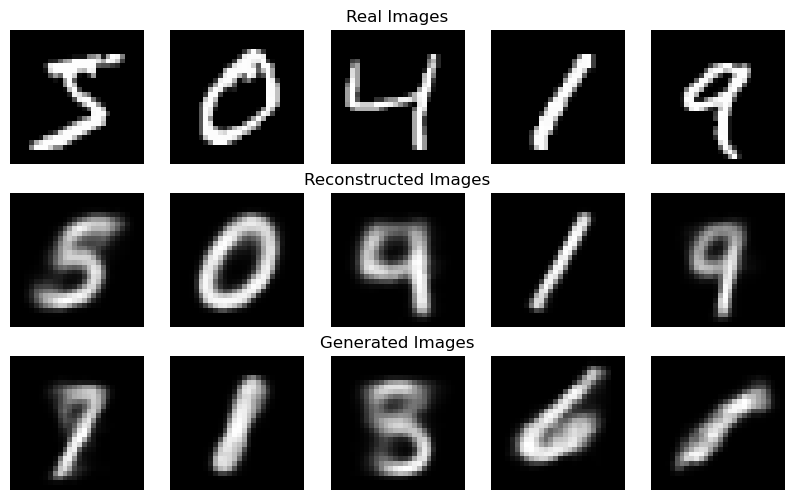

In [79]:
# Visualize reconstruction and generation
visualize_reconstruction_and_generation(model, test_loader, z_dim=2, device=device)

## Section 2.2
Implement a VAE and train it on the MNIST dataset. Use the trained model to detect anomalies by evaluating the reconstruction error. Test your model on a set of anomalous images (e.g., noisy or corrupted MNIST digits) and plot the distribution of reconstruction errors. Set a threshold to classify images as "anomalous" or "normal".

In [51]:
def add_noise_to_images(images, noise_factor=0.5):
    noisy_images = images + noise_factor * torch.randn(*images.shape)
    noisy_images = torch.clip(noisy_images, 0., 1.)
    return noisy_images

def calculate_reconstruction_error(model, images, device):
    model.eval()
    images = images.to(device)
    with torch.no_grad():
        reconstructed_images, _, _ = model(images)

    fig, axs = plt.subplots(1, 2, figsize=(5, 8))
    axs[1].imshow(reconstructed_images[0].cpu().numpy().squeeze(),cmap='gray')
    axs[1].set_title('Reconstructed Image')
    axes[1].axis('off')
    
    axs[0].imshow(images[0].cpu().numpy().squeeze(),cmap='gray')
    axs[0].set_title('Original Image')
    axes[0].axis('off')
    plt.show()

    reconstruction_error = torch.nn.functional.binary_cross_entropy(reconstructed_images, images, reduction='none')
    reconstruction_error = torch.mean(reconstruction_error, dim=[1, 2, 3])
    return reconstruction_error.cpu().numpy()

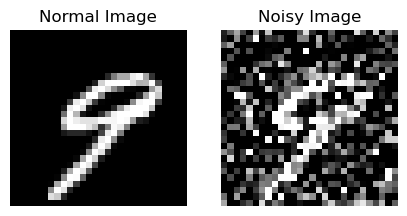

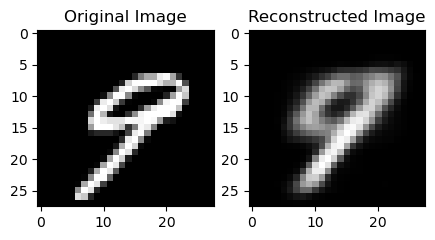

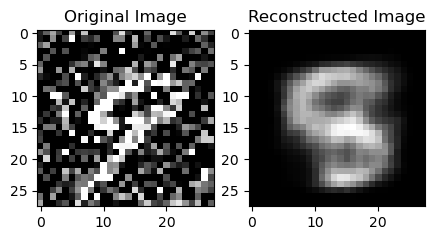

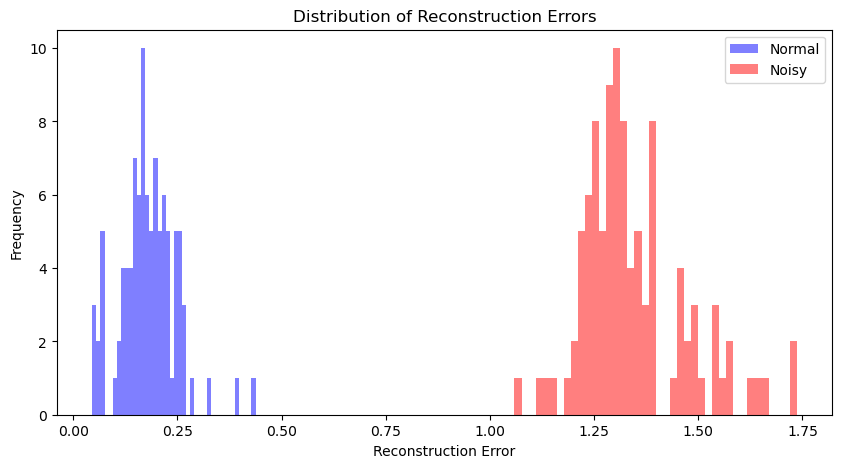

Normal images classified as anomalous: 5 / 100
Noisy images classified as anomalous: 100 / 100


In [56]:
# Get a batch of normal and noisy images
normal_images, _ = next(iter(test_loader))
# Take images from the test_loader randomly
random_indices = random.sample(range(len(test_loader.dataset)), batch_size)
random_sampler = torch.utils.data.Subset(test_loader.dataset, random_indices)
random_loader = DataLoader(random_sampler, batch_size=batch_size, shuffle=False)

# Get a batch of normal and noisy images
normal_images, _ = next(iter(random_loader))
noisy_images = add_noise_to_images(normal_images)

fig, axes = plt.subplots(1, 2, figsize=(5, 8))

# Plot noisy image
axes[1].imshow(noisy_images[0].squeeze(), cmap='gray')
axes[1].set_title('Noisy Image')
axes[1].axis('off')

# Plot normal image
axes[0].imshow(normal_images[0].squeeze(), cmap='gray')
axes[0].set_title('Normal Image')
axes[0].axis('off')

plt.savefig('normal_vs_noisy.png')
plt.show()
# Calculate reconstruction errors
normal_reconstruction_errors = calculate_reconstruction_error(model, normal_images, device)
noisy_reconstruction_errors = calculate_reconstruction_error(model, noisy_images, device)

# Plot the distribution of reconstruction errors
plt.figure(figsize=(10, 5))
plt.hist(normal_reconstruction_errors, bins=40, alpha=0.5, label='Normal',color='b')
plt.hist(noisy_reconstruction_errors, bins=40, alpha=0.5, label='Noisy',color='red')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.legend()
plt.title('Distribution of Reconstruction Errors')
plt.savefig('anomaly_detection.png')
plt.show()

# Set a threshold to classify images as "anomalous" or "normal"
threshold = np.percentile(normal_reconstruction_errors, 95)

# Classify images
normal_classification = normal_reconstruction_errors > threshold
noisy_classification = noisy_reconstruction_errors > threshold

print(f'Normal images classified as anomalous: {np.sum(normal_classification)} / {len(normal_classification)}')
print(f'Noisy images classified as anomalous: {np.sum(noisy_classification)} / {len(noisy_classification)}')

## Section 2.3
After training a VAE on MNIST, visualize the latent space by performing 2D scatter plots of the latent vectors. Color the points based on their digit class (0-9). Discuss how well the latent space clusters based on the digit classes.

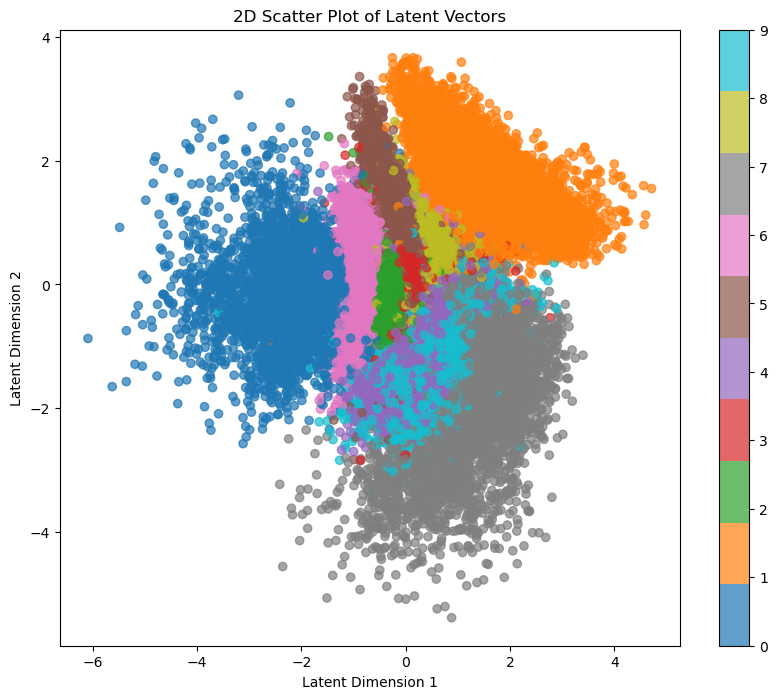

In [57]:
model.eval()
latent_vectors = []
labels = []

with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        mean, logvar = model.encode(x)
        z = model.reparameterization(mean, logvar)
        latent_vectors.append(z.cpu().numpy())
        labels.append(y.cpu().numpy())

latent_vectors = np.concatenate(latent_vectors, axis=0)
labels = np.concatenate(labels, axis=0)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(latent_vectors[:, 0], latent_vectors[:, 1], c=labels, cmap='tab10', alpha=0.7)
plt.colorbar(scatter, ticks=range(10))
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.title('2D Scatter Plot of Latent Vectors')
plt.savefig('latent_space_vis.png')
plt.show()